In [5]:
#this cell handles each image by hand and does over multiple convolutions to try to better smooth the data
#also attempts to correct any units issues

from platform import python_version
print(python_version())


# In[3]:

#importing libraries
from astropy.io import fits
from astropy.convolution import convolve, Gaussian2DKernel, Box2DKernel
from astropy.wcs import WCS
from reproject import reproject_exact  #a package that can be added to astropy using anaconda or pip (see their docs pg)
from reproject import reproject_interp

import glob
import matplotlib 
matplotlib.use('Agg') #invokved b/c just plain matplotlib was insufficient
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys


#switches for the three different parts of this code
switch1 = 'on' #convolving images [needed to put it on for switch 3 at min...need to figure out other solution, eh]
switch1b = 'on' #regridding...
switch2 = 'on' #solving equations
switch3 = 'on' #plotting / graphics of solutions


if switch1 == 'on':

    # In[4]:

    # #finding the path to every fits images in a directory
    def im_name_finder(path, file_type):
        #Using glob (it's a unix command similar to ls)
        #WARNING: using recursive=True...depending how many images you use this could be very slow, it's recommended not to have too many subfolders
        #if needed, some example code is commented towards the latter half of this code that could help make an alternative
        all_names = glob.glob(path, recursive=True)

        #IMPORTANT: Using "fit" here because it is inclusive of both fits and FIT...some files end in "FIT" and need to be included
        #using s.lower() include uppercase names
        im_names = [s for s in all_names if 'fit' in s.lower()]

        return im_names


    # In[5]:

    '''now convolve my image with a PSF of the image we're projecting ONTO
    an approx PSF can be found by assuming a 2D Gaussian func with a width (a FWHM) of the diffrac limit
    that is the st dev of the Gaussian is about the st dev is about = lambda/D
    a list of PSFs are found on https://docs.astropy.org/en/stable/convolution/kernels.html

    Notes:
    FIRST: always must convert hdu1_pixtorad to radians! It's inconsistent otherwise, and lambda/D is generally in radians

    what we're using for the gaussian width is the FWHM, not the radius of the first ring of the diffraction pattern,
    so it's 1.2 not 1.22 times lambda/D

    D is 85 cm for spitzer
    D is 2.4 m for hubble
    '''

    def im_conv(low_res_name, D, hdu_pix_torad, hdu_dat, kern):
        #unfortuantely no good way to find wavelength from header right now. can enter it manually, but I tried to automate it

        #reading in excel file of wavelengths...right now needs to be in same directory as this code
        #first col is a substring of the fits image file name, the second col is the wavelengths in microns
        df = pd.read_excel('../../../imglams.xlsx')
        cols = df.columns
        cols_str = [str(i) for i in df[cols[0]]]
        #some test cases I was using

        #gaussian kernel
        if kern == 'gauss':
            #this finds the loc in the excel file where the image substring matches our image name
            #it then finds the wavelength value corresponding to that loc
            lam =  df.loc[np.where([i in low_res_name for i in cols_str])[0][0]].values[1] #lambda in microns
            
            #finding angular resolution...the FWHM of our Gaussian PSF
            res = 1.2 * lam / D         #resolution in radians
            res = res / hdu_pix_torad        #so converting to pixels

            #finding PSF and then calculating the convolution of our image and the PSF of the image we're projecting onto
            kernel = Gaussian2DKernel(res)
        
        #box kernel
        if kern == 'box':
            kernel = Box2DKernel(16.)

        hdu_conv = convolve(hdu_dat, kernel)
        return hdu_conv



    # In[27]:

    #setting up a new fits file to be saved and viewed in DS9
    #primarily to save the image we reprojected, but can also be used to save the convolved images
    def fits_saver(array, wcs_header, name, save_path):
        '''
        array is a 2d array of data - could be from reprojecting one image onto another or from convolution
        wcs_header is a header containing the wcs coords of the image that we projected onto or of the orig image (if from the convolution)
        name is the path to some image you're using. It will get string split at the / character, and the func only takes the last element of that splitting
        save_path is the folder you want to save to...recommended to also add something to the start of the images names to make it clear what you did to them (e.g. 'Regridded/regrid_')
        '''

        #creating a new file and adding the reprojected array of data as well as the WCS that we projected onto
        hdu_new = fits.PrimaryHDU(array, header=wcs_header)
        hdul = fits.HDUList([hdu_new])

        #saving the file
        new_filename = name.split('/')[-1]  #grabs the file name we were using from before
        hdul.writeto(save_path+new_filename, overwrite=True)

        return (save_path+new_filename)



    # In[21]:

    #EX: grabbing all the fits image paths in a directory, so they can be looped through and their data opened
    #set your path to some directory with images (the images can be in subdirectories)
    #using ** will grab all files even in subdirectories...WARNING this will take longer
    # path = '../../../ngc1333_fits/'
    # im_names_hub_dash = im_name_finder(path+'*', 'fit')
    # im_names_hub_dash = [i.replace('\\', '/') for i in im_names_hub_dash]
    # im_names_hub = [path+'126_image.fits', path+'128_image.fits', path+'164_image.fits', path+'672_image.fits',
    #                 path+'halph_hart_image.fits']

    # In[28]:
    #this time setting up the file names by hand since I've found that easier...
    #order: halpha or .656 mic, 0.672 mic, 1.26, 1.28, 1.64
    files_units = ['../../../../ngc1333_fits/unregridded/656_image.fits', 
                   '../../../../ngc1333_fits/unregridded/0301_flt.fits', 
                   '../../../../ngc1333_fits/unregridded/0501_flt.fits', 
                   '../../../../ngc1333_fits/126build_shift_2_drz.fits', 
                   '../../../../ngc1333_fits/128build_shift_2_drz.fits', 
                   '../../../../ngc1333_fits/164build_shift_2_drz.fits']
    hdu_list_units = [fits.open(i) for i in files_units]
    files_data = ['../../../../ngc1333_fits/656_hareproject.fits', 
                  '../../../../ngc1333_fits/0301_oIreproject2.fits', 
                  '../../../../ngc1333_fits/672_sIIreproject.fits', 
                  '../../../../ngc1333_fits/Background_corr/background_corr_126_aligned.fits', 
                  '../../../../ngc1333_fits/Background_corr/background_corr_128_aligned.fits', 
                  '../../../../ngc1333_fits/Background_corr/background_corr_164_aligned.fits']
    hdu_list = [fits.open(i) for i in files_data]

    hdu_pix_list = []
    hdu_pixtorad_list = []
    hdu_fnu_list = []
    hdu_flam_list = []
    hdu_bw_list = []
    hdu_data_list = []
    hdu_header_list = []
    throughput_list = [1., 1., 1., 1., 1., 1.] # [0.242, 1., 0.246, 0.496, 0.521, 0.470] #also has to be done by hand, not in the headers?


    #I'm using count here just to point to specific indices that I've set up...unfortunately some have different headers...
    #the only diff between the if and else cases are the indexing of the hdu's, some need 1 and some need 0
    #I've tried to group it for convience, so the the first two have the same headers, the last 3 have the same headers
    count = 0
    for (hdu_units,hdu_data) in zip(hdu_list_units, hdu_list):
        if count <= 2: # == 0 or count == 2:
            #reading in conversions
            hdu_pix_list.append(hdu_units[0].header['D001SCAL'])  #D001SCAL is the keyword for Hubble images
            hdu_pixtorad_list.append(hdu_pix_list[count] / 206265.)
            # hdu_fnu_list.append(hdu_units[1].header['PHOTFNU'])
            hdu_flam_list.append(hdu_units[1].header['PHOTFLAM'])
            hdu_bw_list.append(hdu_units[1].header['PHOTBW'])

            #reading in datafor general use  and header for wcs
            hdu_data_list.append(hdu_data[0].data)
            hdu_header_list.append(hdu_data[0].header)

        else:
            #reading in conversions
            hdu_pix_list.append(hdu_units[0].header['D001SCAL'])  #D001SCAL is the keyword for Hubble images
            hdu_pixtorad_list.append(hdu_pix_list[count] / 206265.)
            # hdu_fnu_list.append(hdu_units[0].header['PHOTFNU'])
            hdu_flam_list.append(hdu_units[0].header['PHOTFLAM'])
            hdu_bw_list.append(hdu_units[0].header['PHOTBW'])

            #reading in datafor general use  and header for wcs
            hdu_data_list.append(hdu_data[0].data)
            hdu_header_list.append(hdu_data[0].header)

        count += 1


    #can update later...but basically the sulfur II image header isn't avail...
    #header info taken from https://www.stsci.edu/hst/instrumentation/wfc3/data-analysis/photometric-calibration/uvis-photometric-calibration/quad-filter-photometry
    hdu_flam_list[2] = 1.3699e-17
    hdu_bw_list[2] = 69.98

    print('loaded data!')


    '''
    need to do mutual convolutions...it doesn't look like a loop would help much
    I really couldn't find a loop, so I just do this mostly by hand...
    the basic idea is to run all combinations of convolutions so each image is convolved with each other's psf

    here I'm using the function im_conv, which requires the data file name to find the wavelength, the D for the resolution to convolve to, the pixel conversion, and the data that we are convolving
    '''

    res_str = 'flam' #used to label what we're saving, usually related to units or whether we're doing a gaussian or box convolution, etc
    # resize = 60. #if trying to adjust size of gaussian convolution
    D = 2.4 #/ resize #that of Hubble, in m
    D *= 1e6 #converting to microns since x m / 1 m * 1E6 microns gets microns, the unit of our wavelength file

    #format: conv(data convolving with, Diameter, pix size convolving with, image data to be convolved, convolution method)
    #do each with its own psf
    hdu_conv_list = [im_conv(i, D, j, k, 'gauss') for i,j,k in zip(files_data, hdu_pixtorad_list, hdu_data_list)]

    # #656 and 631
    hdu656_conv = im_conv(files_data[1], D, hdu_pixtorad_list[1], hdu_conv_list[0], 'gauss')

    # #656 and 672
    hdu656_conv = im_conv(files_data[2], D, hdu_pixtorad_list[2], hdu_conv_list[0], 'gauss')
    hdu672_conv = im_conv(files_data[0], D, hdu_pixtorad_list[0], hdu_conv_list[2], 'gauss')

    # #126 and 128
    hdu126_conv = im_conv(files_data[4], D, hdu_pixtorad_list[4], hdu_conv_list[3], 'gauss')
    hdu128_conv = im_conv(files_data[3], D, hdu_pixtorad_list[3], hdu_conv_list[4], 'gauss')

    # #656 and 126
    hdu656_conv = im_conv(files_data[3], D, hdu_pixtorad_list[3], hdu656_conv, 'gauss')
    hdu126_conv = im_conv(files_data[0], D, hdu_pixtorad_list[0], hdu126_conv, 'gauss')

    # #672 and 128
    hdu672_conv = im_conv(files_data[4], D, hdu_pixtorad_list[4], hdu672_conv, 'gauss')
    hdu128_conv = im_conv(files_data[2], D, hdu_pixtorad_list[2], hdu128_conv, 'gauss')

    #164 convolved with all the others and just one of the others with 164, 656 in this case
    hdu672_conv = im_conv(files_data[5], D, hdu_pixtorad_list[5], hdu672_conv, 'gauss')
    hdu126_conv = im_conv(files_data[5], D, hdu_pixtorad_list[5], hdu126_conv, 'gauss')
    hdu128_conv = im_conv(files_data[5], D, hdu_pixtorad_list[5], hdu128_conv, 'gauss')
    hdu164_conv = im_conv(files_data[0], D, hdu_pixtorad_list[0], hdu_conv_list[5], 'gauss') #164 with 656 independently
    hdu656_conv = im_conv(files_data[5], D, hdu_pixtorad_list[5], hdu656_conv, 'gauss') #656 with 164

    #need to do the OI line with everything...
    hdu631_conv = im_conv(files_data[0], D, hdu_pixtorad_list[0], hdu_conv_list[1], 'gauss')

    #recompiling our list
    hdu_conv_list = [hdu656_conv, hdu631_conv, hdu672_conv, hdu126_conv, hdu128_conv, hdu164_conv]


    print('convolved!')
        
    '''
    onto converting units and regridding...
    '''
    #converting the convolved image to correct units and saving it so we can reproject it
    #conversion needed for hubble case since units are not in terms of surface brightness
    hdu_conv_scaled_list = []

    #for each convolved image, we need to convert from e-/s to flambda units which are in erg/s/cm^2/Angstrom...multiply by bw to get rid of angstrom
    #...also images are divided through by throughput, so multiplying by throughput
    #and lastly dividing by the arcsec^2 to get the image in surface brightness units, to be used in regridding
    for count, i in enumerate(hdu_conv_list):

        #a condition added since the background corrected images have units corrected?
        if  count > 2: #the background subtracted images
            hdu_conv_scaled_list.append(i) #/ hdu_pixtorad_list[count]**2. ) #note if doing regridding should also add in , regrid only takes surface brightness
        elif count == 2: #sulfur image or OI
            hdu_conv_scaled_list.append(i * hdu_flam_list[count] * hdu_bw_list[count]) # / hdu_pixtorad_list[count]**2.)# * hdu_flam_list[count] * hdu_bw_list[count] * throughput_list[count]) #note if doing regridding should also add in  / hdu_pixtorad_list[count]**2., regrid only takes surface brightness
        elif count == 0 or count == 1: #Halpha image, no dividing through by pix^2 b/c it's the basis for regridding
            hdu_conv_scaled_list.append(i * hdu_flam_list[count] * hdu_bw_list[count] )




    #you'll need to set the WCS to be that of the header you're basing this off of...ie the header
    file_start = '../../../Convolved_Images_Hub/conv_'+res_str+'_'
    conv_path_list = [] #list of paths to the convolved images, can be useful...


    for count, i in enumerate(hdu_header_list):
        #finding wcs for a given image
        w = WCS(i)
        wcs_header = w.to_header()

        #saving each file to some path, conv_path is the path to that file
        conv_path = fits_saver(hdu_conv_scaled_list[count], wcs_header, files_data[count], file_start)
        conv_path_list.append(conv_path)

    print('saved convolved images!')




    #need a wcs standard for regridding and plots, fits files...
    w = WCS(hdu_header_list[0]) #I picked 0 arbitrarily, it shouldn't really matter
    wcs_header = w.to_header()

    # ##############for regridding just in case...
    
    # if switch1b == 'on':
    #     # I put some options below here just in case

    #     #I only put this here in case later someone wants to regrid the images...
    #     #reprojection of one hdu using the header (coords and pixels) of another
    #     #The first input is the path to the file we're reprojecting. The second input is the header of the image we're projecting ONTO
    #     #para is False for large images (like these hubble ones)
    #     #output is array (a 2D array of data) and footprint (the footprint from the analysis)

    #     #an example of reproject by hand here, but you could loop this, makes things more readable!
    #     hdu_compiled_list = []
    #     regrid_path_list = []
    #     regrid_foot_path_list = []

    #     para = False
    #     file_start = 'Regridded_Hub/regrid_'+res_str+'_'

    #     for count, i in enumerate(hdu_header_list):
    #         if count > 0:
    #             array, footprint = reproject_exact(conv_path_list[count], w, shape_out=hdu_conv_scaled_list[0].shape, parallel=para)
    #             hdu_compiled_list.append(array) #* hdu_pixtorad_list[count]**2.)
    #             #here's what you'd have to do if you were saving from reproject...

    #             #saving a new fits file from the reprojected image
    #             #first, grabbing the WCS coords of the appropriate image to be set as the header of the new image
    #             #in this case, the wcs is set to always be the same
    #             #then we multiply by the pix^2 to get the right units...
    #             # remember to have the right header with the wcs below and that it matches the one we're projecting ONTO
    #             regrid_path = fits_saver(array, wcs_header, files_data[count], file_start) #* hdu_pixtorad_list[count]**2., wcs_header, files_data[count], file_start)
    #             regrid_path_list.append(regrid_path)
    #             regrid_foot_path = fits_saver(footprint * hdu_pixtorad_list[count]**2., wcs_header, files_data[count], file_start+'footprint_')
    #             regrid_foot_path_list.append(regrid_foot_path)

    #         else:
    #             hdu_compiled_list.append(hdu_conv_scaled_list[0])


    #     print('saved regridded images!')
    





    #if you want to divide two of the data files, can do so like
    #data_ratio = np.divide(array, hdu1_conv_scaled, out=np.zeros_like(array), where=hdu1_conv_scaled!=0) #need to do np.divide to guarantee we get no divide by zero issue...

        






3.7.4
loaded data!
convolved!
saved convolved images!


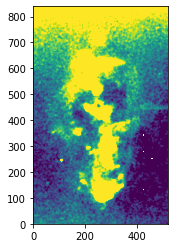

In [44]:
#testing cutouts...
#image plotting in python
def implot(data, w, wcscond, vmax_p, vmin_p):
    fig = plt.figure()
    
    if  wcscond == True:
        fig.add_subplot(111, projection=w)
    else:
        fig.add_subplot(111)
    
    #for christmas turn on GnRd
    #plt.cm.get_cmap('Blues', 6) is another option
    #can also use RdBu...
    #otherwise just use plt.cm.viridis b/c it works
    plt.imshow(data, origin='lower', cmap=plt.cm.viridis, vmin =vmin_p, vmax=vmax_p)
    plt.colorbar()
    plt.xlabel('RA')
    plt.ylabel('Dec')
    
#the entire large region coordinates
cen_x = 550 #690
cen_y = 460 #440
del_x = 520 # 55
del_y = 840 #100

from astropy.nddata import Cutout2D

#trying to cut out the same region in all 4 images
# #HH9? The arcy feature thing
cutout1 = Cutout2D(hdu_conv_scaled_list[0], (cen_x, cen_y), (del_y, del_x), wcs = w.celestial)
datacut1 = cutout1.data
wcscut1 = cutout1.wcs 

cutout2 = Cutout2D(hdu_conv_scaled_list[1], (cen_x, cen_y), (del_y, del_x), wcs = w.celestial)
datacut2 = cutout2.data
wcscut2 = cutout2.wcs 

cutout3 = Cutout2D(hdu_conv_scaled_list[2], (cen_x, cen_y), (del_y, del_x), wcs = w.celestial)
datacut3 = cutout3.data
wcscut3 = cutout3.wcs 

cutout4 = Cutout2D(hdu_conv_scaled_list[3], (cen_x, cen_y), (del_y, del_x), wcs = w.celestial)
datacut4 = cutout4.data
wcscut4 = cutout4.wcs 

#plotting cutouts for all wavelengths
%matplotlib inline
plt.imshow(datacut2, origin='lower', cmap=plt.cm.viridis, vmin =0, vmax=1e-17)
# implot(datacut1[0], wcscut1, True, np.mean(datacut1[0]), 0) 
# implot(hdu_conv_scaled_list[1], w, True, np.mean(hdu_conv_scaled_list[1]), 0) 
# implot(hdu_conv_scaled_list[2], w, True, np.mean(hdu_conv_scaled_list[2]), 0)
# implot(hdu_conv_scaled_list[3], w, True, np.mean(hdu_conv_scaled_list[3]), 0) 

In [6]:
############################################################################################################################################################
#code part 2!
#############################################################################################################################################################

if switch2 == 'on':
    #continuum of filament fluxes
    #again, removing the 1th element here, which corresponds to 672, which we're ignoring for now...
    del hdu_bw_list[1]
    del hdu_bw_list[1]
    bw_arr = np.array(hdu_bw_list) * 1e-8 #converting bandwidth from angstrom to cm, which is what we need for planck's law in cgs...




    '''
    Attempting to loop through all pixels, for whole hh7-11 region
    '''

    '''
    Using 
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.newton_krylov.html#scipy.optimize.newton_krylovfor a non linear solver…

    Try the algebraic solution… open up 4 images, 
    put cursorover same place, see what values are…

    Halpha of 12*.3 (can reduce to reduce negative amt)
    1.2six of 1.3
    Pabeta of 1.2  
    1.six4 of 3

    Q: How long it takes to 12k iterations?
    That’s at me…See how long it takes on my computer 
    vs. Inanna…fora bounded single pixel problem…

    '''


    #global vars for func
    h = 6.626e-27 #CGS units, ergs*sec
    c = 2.998e10 #CGS units, cm/s
    k_B = 1.38e-16 #CGS, ergs/K

    #list of wavelengths for each filter being used ... not sure how to code this automatically
    # lam_arr = 1e-6 * np.array([0.656, 1.26, 1.28, 1.64]) #in SI
    lam_arr = 1e-4 * np.array([0.656, 1.26, 1.28, 1.64]) #in CGS

    #func for planck's law, cgs, output is as a flux
    #https://yceo.yale.edu/sites/default/files/files/ComputingThePlanckFunction.pdf
#     def B_lam(input_arr, temp=3000, const =1e-29):
#         lam, bw = input_arr
#         return const*1e-25 * bw * 2. * h * c**2. / lam**5. * 1. / (np.exp((h * c) / (lam*k_B*temp)) - 1.)

    def B_lam(input_arr, temp=4500, const =1e-29):
        lam = input_arr
        return const * 2. * h * c**2. / lam**5. * 1. / (np.exp((h * c) / (lam*k_B*temp)) - 1.)




In [7]:
if switch2 == 'on':

    #global vars for func
    R_Fe = 2.6 # 2.3
    R_H = 17.5
    y_arr = [0.47245, 0.77307, 0.78015, 0.85001]

#     #for method curve_fit...func for non-linear equation...
#     def scatt_func(lam_arr, C, A_V_fit, f_H, f_Fe):
#         return np.array([
#             (R_H * f_H + B_lam([lam_arr[0], bw_arr[0]], T, C)) * y_arr[0]**A_V_fit, 
#             (R_Fe * f_Fe + B_lam([lam_arr[1], bw_arr[1]], T, C)) * y_arr[1]**A_V_fit,
#             (f_H + B_lam([lam_arr[2], bw_arr[2]], T, C)) * y_arr[2]**A_V_fit,
#             (f_Fe + B_lam([lam_arr[3], bw_arr[3]], T, C)) * y_arr[3]**A_V_fit ])


    #for method newton-krylov redefining function to setup a system of equations equal to 0 
    def scatt_equ_solver(input_arr):
        C, A_V_fit, f_H, f_Fe = input_arr

        equ_sys = pix_flux - np.array([
            (R_H * f_H + B_lam([lam_arr[0], bw_arr[0]], T, C)) * y_arr[0]**A_V_fit, 
            (R_Fe * f_Fe + B_lam([lam_arr[1], bw_arr[1]], T, C)) * y_arr[1]**A_V_fit,
            (f_H + B_lam([lam_arr[2], bw_arr[2]], T, C)) * y_arr[2]**A_V_fit,
            (f_Fe + B_lam([lam_arr[3], bw_arr[3]], T, C)) * y_arr[3]**A_V_fit 
            ])
        return equ_sys
    
    
    #for method there exists method that is setup similar to nk, easier to fit?
    def scatt_equ_lm(input_arr):
        C, A_V_fit, f_H, f_Fe = input_arr

        equ_sys = pix_flux - np.array([
            (R_H * f_H + B_lam([lam_arr[0], bw_arr[0]], T, C)) * y_arr[0]**A_V_fit, 
            (R_Fe * f_Fe + B_lam([lam_arr[1], bw_arr[1]], T, C)) * y_arr[1]**A_V_fit,
            (f_H + B_lam([lam_arr[2], bw_arr[2]], T, C)) * y_arr[2]**A_V_fit,
            (f_Fe + B_lam([lam_arr[3], bw_arr[3]], T, C)) * y_arr[3]**A_V_fit 
            ])
        
#         sum_sys = np.sqrt(np.sum((obs-theory)**2./obs**2. for (obs,theory) in zip(pix_flux, equ_sys)))
        
        return equ_sys
    


        #for method curve_fit...func for non-linear equation...
    def scatt_func(lam_arr, C, A_V_fit, f_H, f_Fe):
        return np.array([
            (R_H * f_H + B_lam(lam_arr[0], T, C)) * y_arr[0]**A_V_fit, 
            (R_Fe * f_Fe + B_lam(lam_arr[1], T, C)) * y_arr[1]**A_V_fit,
            (f_H + B_lam(lam_arr[2], T, C)) * y_arr[2]**A_V_fit,
            (f_Fe + B_lam(lam_arr[3], T, C)) * y_arr[3]**A_V_fit ])


#     #for method newton-krylov redefining function to setup a system of equations equal to 0 
#     def scatt_equ_solver(input_arr):
#         C, A_V_fit, f_H, f_Fe = input_arr

#         equ_sys = pix_flux - np.array([
#             (R_H * f_H + B_lam(lam_arr[0], T, C)) * y_arr[0]**A_V_fit, 
#             (R_Fe * f_Fe + B_lam(lam_arr[1], T, C)) * y_arr[1]**A_V_fit,
#             (f_H + B_lam(lam_arr[2], T, C)) * y_arr[2]**A_V_fit,
#             (f_Fe + B_lam(lam_arr[3], T, C)) * y_arr[3]**A_V_fit 
#             ])
#         return equ_sys



    print('set up functions for fitting!')

    #attempting many solvers
    from scipy.optimize import newton_krylov
    from scipy.optimize import curve_fit
    from scipy.optimize import least_squares


    #scaling by the signal to noise
    #from the regridded, convolved images...I collected the noise, though apparently it's not needed if we use background corrected images
    noise_656 = 4.4e-20 #* 0.242  # 0.302712 / 4.25e10 #multiplied these by throughputs
    noise_631 = 6e-20
    noise_672 = 8.70052e-20 #* 0.242  # 0.302712 / 4.25e10 #multiplied these by throughputs
    noise_126 = 2.6e-18 #* 0.496 #  0.216037 / 4.25e10 #times by throughput
    noise_128 = 2.75e-18 #* 0.521 # 0.258513 / 4.25e10 #times by throughput
    noise_164 = 5.766e-18  #* 0.470 # 0.39321 / 4.25e10 #times by throughput
    noise_list = [noise_656, noise_631, noise_672, noise_126, noise_128, noise_164]

    #looping through noise to invoke a singal to noise correction...can omit when using background corrected images
    data_corrected_list = []
    perc = 1e0 #this tends to work?? Maybe can change...

    for data,noise in zip(hdu_conv_scaled_list, noise_list):   #OMITTED NOISE CORRECTION AS ATTEMPT, BUT WILL NEED IT EVENTUALLY.....
        data[data < -noise*perc] = np.nan
        data_corrected_list.append(data)

    #trying to save the sulfur image?
    # first saving as fits files, the 'ex/' is just because fits_Saver picks out all characters after a '/'
    nonlin_folder = 'fitting_withOI/local_machine' 
    file_start = nonlin_folder + '/nonlin_'+res_str+'_'
    regrid_path = fits_saver(data_corrected_list[0], wcs_header, 'ex/0_656_mic.fits', file_start)
    regrid_path = fits_saver(data_corrected_list[1], wcs_header, 'ex/0_631_mic.fits', file_start)  
    regrid_path = fits_saver(data_corrected_list[2], wcs_header, 'ex/0_672_mic.fits', file_start)
    regrid_path = fits_saver(data_corrected_list[3], wcs_header, 'ex/1_26_mic.fits', file_start)
    regrid_path = fits_saver(data_corrected_list[4], wcs_header, 'ex/1_28_mic.fits', file_start)
    regrid_path = fits_saver(data_corrected_list[5], wcs_header, 'ex/1_64_mic.fits', file_start)

    #then used .del(1) here because we aren't trying to fit the 672 line image yet...can adjust that!
    # del hdu_compiled_list[1]
    # del hdu_compiled_list[1] #here we're doing the same number b/c after deleting one element, the rest of the stack moved down
    del hdu_conv_scaled_list[1] 
    del hdu_conv_scaled_list[1] #here we're doing the same number b/c after deleting one elemtn, the rest of the stack moved down   
    del data_corrected_list[1] 
    del data_corrected_list[1] #here we're doing the same number b/c after deleting one elemtn, the rest of the stack moved down


    # cont_flux2 = np.array(data_corrected_list)  #if going for data with holes?
    cont_flux2 = np.array(hdu_conv_scaled_list)  #if going for data without holes?

    #array of zeros to contain fit data...
    fit_arr2 = [[] for x in range(cont_flux2[0].shape[0] * cont_flux2[0].shape[1])]
    count = 0 #count variable to index this list
    
    

        #different initial guesses (C, Av, Fe, H)
#     xin_nk = np.array([1., 4.7, 5e-18, 2e-18])
    # xin_nk = np.array([5.63120728, 8.45, 8.64e-17, 7.11e-17]) #from when I was using images divided through by throughput
#     xin2 = [3.11706881e-30, 5., 2.79259524e-17, 4.48608665e-17]  #[1., 4.7, 5e-18, 2e-18]
#     xin_nk = np.array([5., 5., 8.17922089e-18, 3.68824803e-18])  
    xin2 = [5e-29, 5., 8.17922089e-18, 3.68824803e-18]
#     xin_nk = [3.11706881e-30, 5., 2.79259524e-17, 4.48608665e-17]   #np.array([1.5, 4.7, 5e-17, 5e-17])
    
    # nonlin_folder = 'nonlinfits' 
    # Tstart = 6000.
    # Cbound = 0
    # Cinit = -1.
    # Tend = 3000.
    # T_increment = 25.
    # res_str_fit = 'Cneg_0_perc-1_start6000_end3000_inc25_withOI'

    # nonlin_folder = 'nonlinfits' 
    Tstart = 2500.
    Cbound = 0
    Cinit = -1.
    Tend = 400.
    T_increment = 50
    res_str_fit = 'start2500end400inc50' #'C5_lt0_perc-0_start6000_end2000_inc400_AV5_f5E-18_ratio2_3_withOI'
    
    #beginning loop...
    for i in range(cont_flux2[0].shape[0]):
        for j in range(cont_flux2[0].shape[1]):
            pix_flux = np.array([cont_flux2[0][i, j], cont_flux2[1][i, j], cont_flux2[2][i, j], cont_flux2[3][i, j]])
    #         sigma_arr = [cont_flux[0][i, j]/1e5, cont_flux[1][i, j]/1e5, cont_flux[2][i, j]/1e5, cont_flux[3][i, j]/1e5]
    
            fit_test = [] #for use if trying to find best fitting temperature                           
            try:
                
                                #trying Dan's method of setting temperature...
                T = Tstart
                C_fit = Cinit
#                 trap_count = 0
                while T > Tend:# and C_fit < Cbound:
#                 algo = 'lm'
#                 for T in range(Tstart, Tend, inc):
 
        #           #now setting up for curve_fit
                    popt, pcov = curve_fit(scatt_func, lam_arr, pix_flux, p0=xin2)#, bounds=([0,0,0,0], [np.inf,np.inf,np.inf,np.inf])) #solving!
                    C_fit, A_V_fit, f_H_fit, f_Fe_fit = popt
#                     solved = least_squares(scatt_equ_lm, xin2) #non-lin solver
#                     C_fit, A_V_fit, f_H_fit, f_Fe_fit = solved

                    #chi^2 test...against curve_fit
                    #with an approx rms like or chi^2 quantity can then compare the fit values to the observed values
                    #can then be used to 
                    obs_intens = pix_flux
                    theory_intens = scatt_func(lam_arr, C_fit, A_V_fit, f_H_fit, f_Fe_fit)
                    n_obs = len(obs_intens)
                    rms = np.sqrt(np.sum((obs_intens - theory_intens)**2./(obs_intens)**2.)) 
                    
                    #saving results
                    fit_test.append([i, j, rms, theory_intens, T, C_fit, A_V_fit, f_H_fit, f_Fe_fit])
#                     fit_arr2[count] = [i, j, rms, theory_intens, T, C_fit, A_V_fit, f_H_fit, f_Fe_fit]

                    T -= T_increment
                    # trap_count += 1
                
                rms_test = [test[2] for test in fit_test] #extracting the rms values 
#                 print(fit_test)
#                 print(rms_test)
#                 print(np.argmin(rms_test))
                fit_arr2[count] = fit_test[np.argmin(rms_test)] #np.argmin finds minimizes the error, finds best fit
#                 print(algo, T)
                
    

#             #should try newton krylov as backup...
#             except Exception as e: 
            
#                 #trying to get fit
#                 try:

            
#     #                     #trying Dan's method of setting temperature...
#                     T = Tstart
#                     C_fit = Cinit
#                     # trap_count = 0
#                     algo = 'nk'
#                     while C_fit < Cbound and T > Tend:

#                         solved = newton_krylov(scatt_equ_solver, xin_nk)#, f_tol=1e-14, method='gmres') #non-lin solver. ftol 1E-8ish with gmres
#                         #separating fit into diff variables...calculating a sum of squared diffs
#                         C_nk, A_V_fitnk, f_H_nk, f_Fe_nk = solved

#                         #calculating sum of squared diffs...against newton-krylov
#                         obs_intens = pix_flux
#                         theory_intens = scatt_func(lam_arr, C_nk, A_V_fitnk, f_H_nk, f_Fe_nk)
#                         chi2 = np.sum((pix_flux - theory_intens)**2.)

#                         #saving results
#                         fit_arr2[count] = [i, j, chi2, theory_intens, T, C_nk, A_V_fitnk, f_H_nk, f_Fe_nk]

#                         T -= T_increment
#                         # trap_count += 1

#         #                     print(algo, T)

            except Exception as e2: #in case no fit can be found...
#                 print('type is:', e2.__class__.__name__)
#                 print('no fit found')
                fit_arr2[count] = [i, j, np.nan, [np.nan, np.nan, np.nan, np.nan], np.nan, np.nan, np.nan, np.nan, np.nan]


            count += 1


    print('ran nonlin fit!')


    #saving fits...

    #setting up array of equation variables
    f_H_arr = np.zeros_like(cont_flux2[0])
    f_Fe_arr = np.zeros_like(cont_flux2[0])
    C_arr = np.zeros_like(cont_flux2[0])
    A_V_arr = np.zeros_like(cont_flux2[0])
    T_arr = np.zeros_like(cont_flux2[0])
    rms_arr = np.zeros_like(cont_flux2[0])


    ind = 3 # used for picking type of image to plot
    #reorganizing data in 2d array to be plotted

    for line in fit_arr2:

        #indices
        i = line[0]
        j = line[1]
        rms_arr[i][j] = line[2]
        T_arr[i][j] = line[-5]
        C_arr[i][j] = line[-4]
        A_V_arr[i][j] = line[-3]
        f_H_arr[i][j] = line[-2]
        f_Fe_arr[i][j] = line[-1]


    #saving data files
    np.savetxt(nonlin_folder + '/solverhh711_rms.txt', rms_arr)
    np.savetxt(nonlin_folder + '/solverhh711_T.txt', T_arr)
    np.savetxt(nonlin_folder + '/solverhh711_C.txt', C_arr)
    np.savetxt(nonlin_folder + '/solverhh711_Av.txt', A_V_arr)
    np.savetxt(nonlin_folder + '/solverhh711_fH.txt', f_H_arr)
    np.savetxt(nonlin_folder + '/solverhh711_fFe.txt', f_Fe_arr)




set up functions for fitting!


C:\Users\Adam2\Anaconda\envs\mypython3\lib\site-packages\ipykernel_launcher.py:93: RuntimeWarning: invalid value encountered in less
C:\Users\Adam2\Anaconda\envs\mypython3\lib\site-packages\ipykernel_launcher.py:177: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Adam2\Anaconda\envs\mypython3\lib\site-packages\ipykernel_launcher.py:177: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Adam2\Anaconda\envs\mypython3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: overflow encountered in double_scalars


ran nonlin fit!


In [8]:
#at this point, it's probably good to work interactively, maybe open up your ipython environment!
#plotting solution found for hh7-11 region
if switch3 == 'on':
    #loading data files
    rms_arr = np.loadtxt(nonlin_folder + '/solverhh711_rms.txt')
    T_arr = np.loadtxt(nonlin_folder + '/solverhh711_T.txt')
    C_arr = np.loadtxt(nonlin_folder + '/solverhh711_C.txt')
    A_V_arr = np.loadtxt(nonlin_folder + '/solverhh711_Av.txt')
    f_H_arr = np.loadtxt(nonlin_folder + '/solverhh711_fH.txt')
    f_Fe_arr = np.loadtxt(nonlin_folder + '/solverhh711_fFe.txt')

    #image plotting in python
    # import matplotlib.colors #to change colorbar? https://stackoverflow.com/questions/27345005/log-labels-on-colorbar-matplotlib

    def implot(data, title, w, wcscond, vmax_p, vmin_p):
        fig = plt.figure()
        
        if  wcscond == True:
            fig.add_subplot(111, projection=w)
        else:
            fig.add_subplot(111)
        
        #for christmas turn on GnRd
        #plt.cm.get_cmap('Blues', 6) is another option
        #can also use RdBu...
        #otherwise just use plt.cm.viridis b/c it works

        # if vmax_p != None:
        plt.imshow(data, origin='lower', cmap=plt.cm.viridis, vmax=vmax_p, vmin=vmin_p)#, norm=matplotlib.colors.LogNorm())#, vmin =vmin_p)
        # else:
        #     plt.imshow(data, origin='lower', cmap=plt.cm.viridis)

        plt.colorbar()
        plt.xlabel('RA')
        plt.ylabel('Dec')

        plt.title(title)
        plt.savefig(nonlin_folder + '/nonlinfit_image_'+title+'.png')
        plt.cla()

#     res_str_fit = '' # 'C5E-29_lt0_perc-0_start2000_end1700_inc100_AV4_7_f5E-17_ratio2_3_withOI'
    file_start = nonlin_folder + '/nonlin_'+res_str_fit+'_'
    regrid_path = fits_saver(rms_arr, wcs_header, 'ex/rms.fits', file_start)
    regrid_path = fits_saver(T_arr, wcs_header, 'ex/T.fits', file_start)
    regrid_path = fits_saver(C_arr, wcs_header, 'ex/C.fits', file_start)
    regrid_path = fits_saver(A_V_arr, wcs_header, 'ex/A_V.fits', file_start)
    regrid_path = fits_saver(f_H_arr, wcs_header, 'ex/f_H.fits', file_start)
    regrid_path = fits_saver(f_Fe_arr, wcs_header, 'ex/f_Fe.fits', file_start)
            
    #plotting equation fits
    # implot(C_arr, 'C', w, True, 1e-25, 0)#, np.max(C_arr), np.min(C_arr))
    # implot(A_V_arr, 'A_V', w, True, 20, None)#, np.max(A_V_arr), np.min(A_V_arr))
    # implot(f_H_arr, 'f_H', w, True, 5e-17, 0)#, np.max(f_H_arr), np.min(f_H_arr))
    # implot(f_Fe_arr, 'f_Fe', w, True, 5e-17, 0)#, np.max(f_Fe_arr), np.min(f_Fe_arr))


    # #plotting cutouts of actual data
    # implot(hdu_conv_scaled_list[0], '0_656_mic_HAlpha_', w, False, 1e-18, 0)#, np.max(datacut1), np.min(datacut1))
    # implot(hdu_conv_scaled_list[1], '1_26_mic', w, False, 5e-17, 0)#, np.max(datacut2), np.min(datacut2))
    # implot(hdu_conv_scaled_list[2], '1_28_mic', w, False, 5e-17, 0)#, np.max(datacut3), np.min(datacut3))
    # implot(hdu_conv_scaled_list[3], '1_64_mic', w, False, 5e-17, 0)#, np.max(datacut4), np.min(datacut4))

    # plt.close('all') #otherwise figure axes might not get saved
    print('saved images and files!')



    #making continuum image
    # count = 0
    # for bw,lam in zip(bw_arr, lam_arr):
    #     cont_calc = C_arr * 1e-25 * bw * 2. * h * c**2. / lam**5. * 1. / (np.exp((h * c) / (lam*k_B*T_arr)) - 1.)
    #     new_path = fits_saver(cont_calc, wcs_header, 'ex/cont'+str(count)+'.fits', file_start)
    #     count += 1


    # print('making bb img')

saved images and files!
